# Adjoint

The adjoint protocol lets you request the adjoint of a bloq.

Namely, if a given bloq represents a linear operator, this protocol returns a bloq representing the [Hermitian adjoint](https://en.wikipedia.org/wiki/Hermitian_adjoint) ("Hermitian conjugate" or "adjoint") of the original operator. When the operators are represented by matrices, the adjoint is the conjugate transpose.

Below we see that $\left(|0\rangle\right)^\dagger = \langle 0|$.

Note: in mathematical notation, we apply operators from right to left. In Qualtran drawings (inspired by tensor networks and quantum circuits), the order goes from left to right.

ZeroState


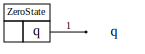

ZeroEffect


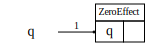

In [1]:
from qualtran.drawing import show_bloq
from qualtran.bloqs.basic_gates import ZeroState

print(ZeroState())
show_bloq(ZeroState())
print(ZeroState().adjoint())
show_bloq(ZeroState().adjoint())

## Interface

The method for accessing the adjoint of a bloq is calling the `Bloq.adjoint()` method on the bloq.

Of particular note is the `CompositeBloq.adjoint()` override which codifies the "anti-distributivity" of the adjoint: $(AB)^\dagger = B^\dagger A^\dagger$.

The adjoint of a composite bloq reverses the direction of the flow of data (i.e. it reverses the order of operations) and uses the adjoint of each sub-bloq. 

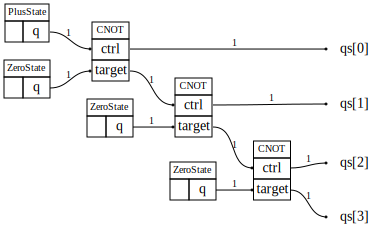

In [2]:
import numpy as np

from qualtran import BloqBuilder
from qualtran.bloqs.basic_gates import ZeroState, PlusState, CNOT

# Construct a bell state by doing a ladder of CNOTs
bb = BloqBuilder()
q0 = bb.add(PlusState())

src_q = q0  # current wire
qvars = []  # track output wires
for _ in range(3):
    next_q = bb.add(ZeroState())
    src_q, next_q = bb.add(CNOT(), ctrl=src_q, target=next_q)
    
    qvars.append(src_q)
    src_q = next_q
    
qvars.append(src_q)
bell_cbloq = bb.finalize(qs=np.array(qvars))
show_bloq(bell_cbloq)

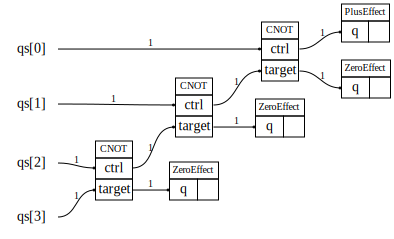

In [3]:
# Take the adjoint of a composite bloq
show_bloq(bell_cbloq.adjoint())

## Implementation

Bloq authors can override `Bloq.adjoint()` in certain circumstances.

 - If the bloq is self-adjoint. For example, many common gates like `CNOT` and `XGate` are self-adjoint, i.e. $U=U^\dagger$.
 - If there is an optimized compilation for the adjoint. For example, `And` has a special construction that only works when un-computing.

In [4]:
from qualtran.bloqs.basic_gates import CNOT, XGate

# Examples of self-adjoint bloqs.
print('X == X^dag:      ', XGate() == XGate().adjoint())
print('CNOT == CNOT^dag:', CNOT() == CNOT().adjoint())

X == X^dag:       True
CNOT == CNOT^dag: True


In [5]:
# A bloq with a special construction (and reduced cost) for its adjoint.

from qualtran.bloqs.mcmt import And
from qualtran.drawing import show_counts_sigma

_, forward_costs = And().call_graph()
_, backward_costs = And().adjoint().call_graph()
show_counts_sigma(forward_costs)
show_counts_sigma(backward_costs)

#### Counts totals:
 - `ArbitraryClifford(n=2)`: 9
 - `T`: 4

#### Counts totals:
 - `ArbitraryClifford(n=2)`: 4

## Default Fallback

If a bloq does not override `.adjoint()`, the system will use the `qualtran.Adjoint` meta-bloq to wrap the original bloq.

In [6]:
from qualtran.bloqs.for_testing import TestSerialCombo

bloq = TestSerialCombo()
bloq.adjoint()

Adjoint(subbloq=TestSerialCombo())

This metabloq forms an important part of the adjoint protocol. It adapts the other qualtran protocols to resepct the adjoint-edness of the wrapped subbloq.

The `Adjoint` bloq generally delegates all of its protocols to `self.subbloq`:

 - **Signature**: The signature is the adjoint of `subbloqs`'s signature. Namely, LEFT
   and RIGHT registers are swapped.
 - **Decomposition**: The decomposition is the adjoint of `subbloq`'s decomposition. Namely,
   the order of operations in the resultant [`CompositeBloq`](/reference/qualtran/CompositeBloq.md) is reversed and each bloq is
   replaced with its adjoint.
 - **Adjoint**: The adjoint of an `Adjoint` bloq is the subbloq itself.
 - **Call graph**: The call graph is the subbloq's call graph, but each bloq is replaced
   with its adjoint.
 - **Cirq Interop**: The default [`Bloq`](/reference/qualtran/Bloq.md) implementation is used, which goes via `BloqAsCirqGate`
   as usual.
 - **Wire Symbol**: The wire symbols are the adjoint of `subbloq`'s wire symbols. Namely,
   left- and right-oriented symbols are flipped.
 - **Names**: The string names / labels are that of the `subbloq` with a dagger symbol appended.
 
Some protocols are impossible to delegate specialized implementations. The `Adjoint` bloq
supports the following protocols with "decompose-only" implementations. This means we always
go via the bloq's decomposition instead of preferring specialized implementations provided by
the bloq author. If a specialized implementation of these protocols are required or you
are trying to represent an adjoint bloq without a decomposition and need to support these
protocols, you cannot use the default fallback method.

 - Classical simulation is "decompose-only". It is impossible to invert a generic python
   function.
 - Tensor simulation is "decompose-only" due to technical details around the Quimb interop.

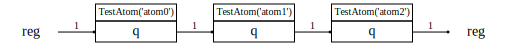

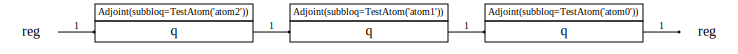

In [7]:
# The decomposition is the adjoint of the wrapped bloq's decomposition
show_bloq(bloq.decompose_bloq())
show_bloq(bloq.adjoint().decompose_bloq())

In the next cell, we write a quick block that has a non-trivial adjoint. We'll take a look at its decomposition and tensor contraction.

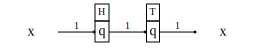

In [8]:
from functools import cached_property
from typing import *

from qualtran import BloqBuilder, Bloq, Signature, SoquetT
from qualtran.bloqs.basic_gates import TGate, Hadamard

class TStateMaker(Bloq):
    @cached_property
    def signature(self) -> 'Signature':
        return Signature.build(x=1)

    def build_composite_bloq(self, bb: 'BloqBuilder', x: 'SoquetT') -> Dict[str, 'SoquetT']:
        x = bb.add(Hadamard(), q=x)
        x = bb.add(TGate(), q=x)
        return {'x': x}
    
show_bloq(TStateMaker().decompose_bloq())

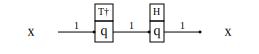

In [9]:
# Use the default fallback for `.adjoint()`
show_bloq(TStateMaker().adjoint().decompose_bloq())

In [10]:
unitary = TStateMaker().tensor_contract()
adj_unitary = TStateMaker().adjoint().tensor_contract()
np.testing.assert_allclose(unitary.conj().T, adj_unitary)
print("Check!")

Check!


## Additional Functionality

[`Signature`](/reference/qualtran/Signature.md), [`Register`](/reference/qualtran/Register.md), and `qualtran.drawing.WireSymbol` also provide an `adjoint` method which returns a version of the object with "right" and "left" reversed.